In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [3]:
# Load the dataset
file_path = r"C:\Users\Joseph\Desktop\School\Masters Data Science\Predictive Analytics\Loan_default.csv"
data = pd.read_csv(file_path)

# Data Prep

In [4]:
data.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [5]:
# Impute missing values
num_cols = data.select_dtypes(include=['float64', 'int64']).columns
cat_cols = data.select_dtypes(include=['object']).columns

imputer_num = SimpleImputer(strategy='mean')
imputer_cat = SimpleImputer(strategy='most_frequent')

data[num_cols] = imputer_num.fit_transform(data[num_cols])
data[cat_cols] = imputer_cat.fit_transform(data[cat_cols])

In [6]:
# Check column names
print(data.columns)

Index(['LoanID', 'Age', 'Income', 'LoanAmount', 'CreditScore',
       'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm',
       'DTIRatio', 'Education', 'EmploymentType', 'MaritalStatus',
       'HasMortgage', 'HasDependents', 'LoanPurpose', 'HasCoSigner',
       'Default'],
      dtype='object')


In [7]:
# Creating Debt-to-Income ratio
data['debt_to_income'] = data['LoanAmount'] / data['Income']

# Specify the categorical columns
categorical_cols = ['Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose', 
                    'HasMortgage', 'HasDependents', 'HasCoSigner']

# one-hot encoding
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [8]:
# Split the dataset into training and test sets
X = data.drop('Default', axis=1)  # Features
y = data['Default']               # Target variable

In [9]:
# Check the data types of the columns
print(X.dtypes)

LoanID                           object
Age                             float64
Income                          float64
LoanAmount                      float64
CreditScore                     float64
MonthsEmployed                  float64
NumCreditLines                  float64
InterestRate                    float64
LoanTerm                        float64
DTIRatio                        float64
debt_to_income                  float64
Education_High School              bool
Education_Master's                 bool
Education_PhD                      bool
EmploymentType_Part-time           bool
EmploymentType_Self-employed       bool
EmploymentType_Unemployed          bool
MaritalStatus_Married              bool
MaritalStatus_Single               bool
LoanPurpose_Business               bool
LoanPurpose_Education              bool
LoanPurpose_Home                   bool
LoanPurpose_Other                  bool
HasMortgage_Yes                    bool
HasDependents_Yes                  bool


In [10]:
# Drop the 'LoanID' column as it is not useful for prediction
X = X.drop('LoanID', axis=1)

# Convert boolean columns to integers (1 for True, 0 for False)
X = X.astype(int)

# apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [11]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [12]:
# Standardize the numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Building and Evaluating the Model

In [13]:
# Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, max_features='sqrt', random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

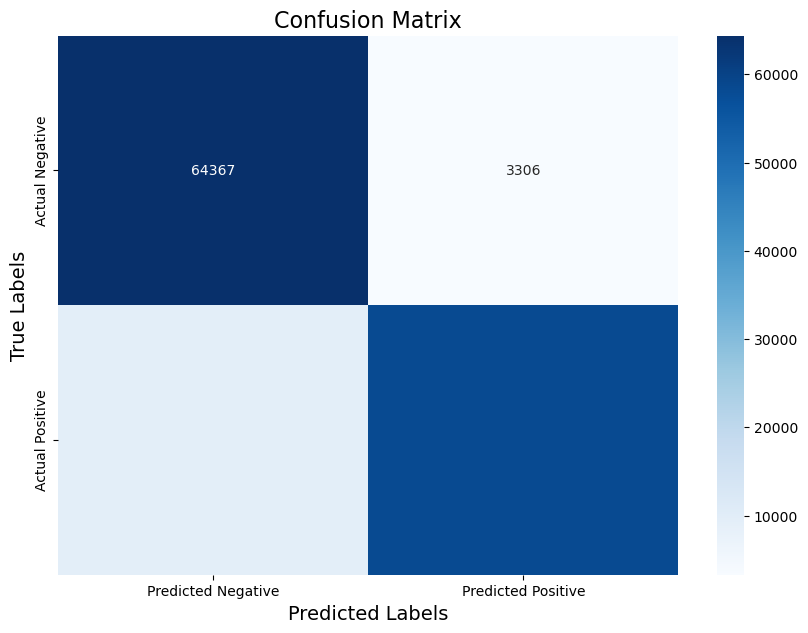

[[64367  3306]
 [ 9517 58227]]
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     67673
         1.0       0.95      0.86      0.90     67744

    accuracy                           0.91    135417
   macro avg       0.91      0.91      0.91    135417
weighted avg       0.91      0.91      0.91    135417



In [14]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Set up the matplotlib figure
plt.figure(figsize=(10, 7))

# Create a heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])

# Titles and labels
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)

# Show the plot
plt.show()

# Confusion Matrix and Classification Report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

In [15]:
# AUC-ROC Curve
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'AUC-ROC Score: {roc_auc}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

AUC-ROC Score: 0.9569479678218092


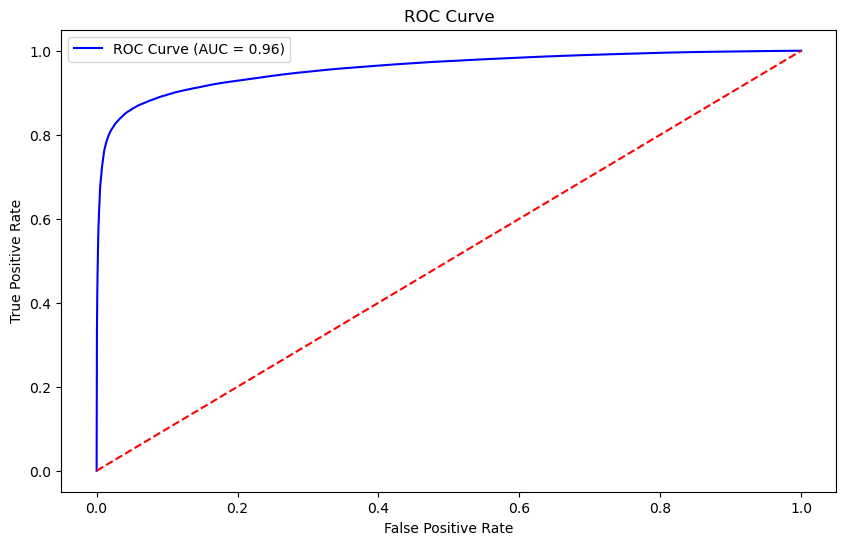

In [16]:
# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
plt.plot([0, 1], [0, 1], "r--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

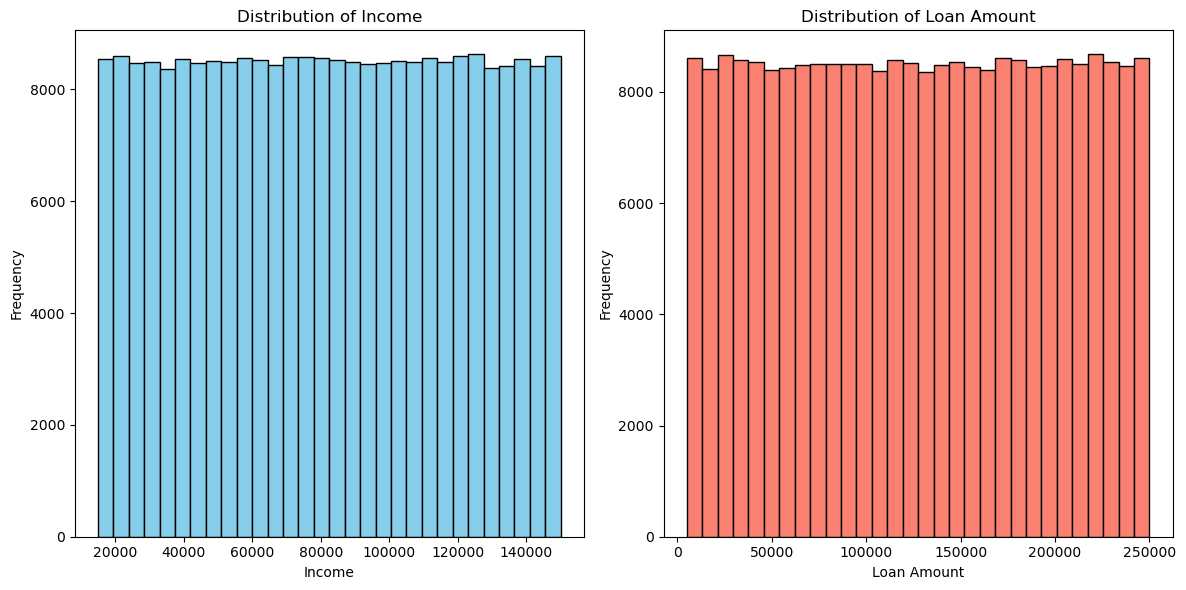

In [17]:
# Create histograms for Income and Loan Amount
plt.figure(figsize=(12, 6))

# Plot histogram for Income
plt.subplot(1, 2, 1)
plt.hist(data['Income'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Frequency')

# Plot histogram for Loan Amount
plt.subplot(1, 2, 2)
plt.hist(data['LoanAmount'], bins=30, color='salmon', edgecolor='black')
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

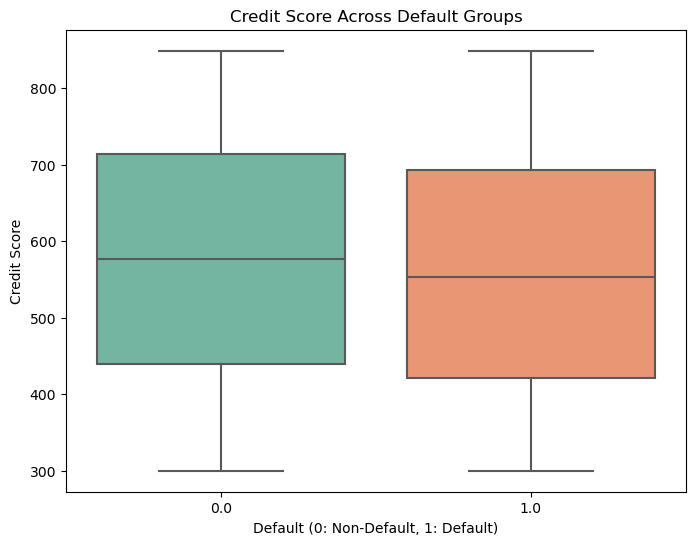

In [18]:
# Create a box plot for Credit Score across Default groups
plt.figure(figsize=(8, 6))
sns.boxplot(x='Default', y='CreditScore', data=data, palette='Set2')
plt.title('Credit Score Across Default Groups')
plt.xlabel('Default (0: Non-Default, 1: Default)')
plt.ylabel('Credit Score')
plt.show()